In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

from models import GeneratorResNet
from dataset import PPG2ECG_Dataset_Eval
from make_args import Args

- args

In [2]:
args = Args('./config/CycleGAN_PPG2ECG.json')

- Define Device

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print("Using Pytorch Versions:", torch.__version__, ' Device:', DEVICE)

Using Pytorch Versions: 2.1.1+cu118  Device: cuda


- get dataloader

In [4]:
partition = np.load(args.partition_path, allow_pickle=True).item()

valset = partition['valset']

In [5]:
num_worker = args.num_workers

trainloader_instance = PPG2ECG_Dataset_Eval(valset, sampling_rate=args.target_sampling_rate, 
                                           min_max_norm=args.min_max_norm, z_score_norm=args.z_score_norm, interp=args.interp_method)

- load model

In [6]:
weights_path = './model_result/CycleGAN/PPG2ECG_CycleGAN_3Epochs.pth'
input_shape = (None, 1, int(args.target_sampling_rate * args.sig_time_len))
n_residual_blocks=args.n_residual_blocks

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
weights = torch.load(weights_path, map_location=DEVICE)
G_AB.load_state_dict(weights['G_AB'])
G_AB.to(DEVICE)
G_AB.eval()

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad1d((1, 1))
    (1): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(1,))
    (2): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(2,))
    (5): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(2,))
    (8): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad1d((1, 1))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
        (2): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): LeakyReLU(neg

- inference

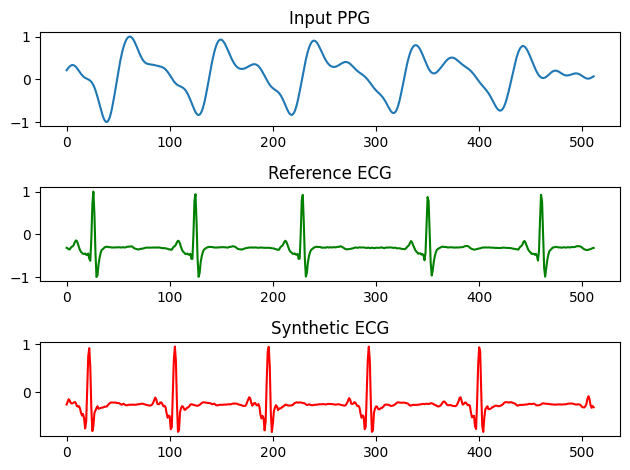

In [12]:
se_idx = -1000
input_data = trainloader_instance[se_idx]
input_ppg, ref_ecg = input_data['ppg'], input_data['ecg']

syn_ecg = G_AB(input_ppg.unsqueeze(0).to(DEVICE))[0]
syn_ecg = syn_ecg.data.cpu().numpy()

fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(input_ppg[0])
plt.title('Input PPG')

plt.subplot(3, 1, 2)
plt.plot(ref_ecg[0], c='g')
plt.title('Reference ECG')

plt.subplot(3, 1, 3)
plt.plot(syn_ecg[0], c='r')
plt.title('Synthetic ECG')
fig.tight_layout()